In [1]:
import numpy as np
import pandas as pd
import csv
import time
#torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader # For batching graph data
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F

#sklearn
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

# objective functions
from utils import theta_regularizer, neighbor_distance_regularizer

#Visualize and create graph/charts
import networkx as nx
import matplotlib.pyplot as plt

#Path managment
import os
import sys



from IPython.display import clear_output
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.seed = 1234
torch.__version__, torch.version.cuda

('2.7.0+cu126', '12.6')

In [2]:
# To reload modulse if needed
%reload_ext autoreload
%autoreload 2

### Add the DGDNN libraries into the path to get Data

In [3]:
current_dir = os.getcwd() #till /.../home/..../code


model_path = os.path.join(current_dir, 'models/DGDNN/Model')
if model_path not in sys.path:
    sys.path.insert(0, model_path)
data_path = os.path.join(current_dir, 'models/DGDNN/Data')
if data_path not in sys.path:
    sys.path.insert(0, data_path)


# The dataset 

In [4]:
from geometric_dataset_gen import MyDataset as MyGeometricDataset
from dataset_gen import MyDataset 

In [5]:
# # Configure the default variables // # these can be tuned // # examples
sedate = ['2013-01-01', '2014-12-31']  # these can be tuned
val_sedate = ['2015-01-01', '2015-06-30'] # these can be tuned
test_sedate = ['2015-07-01', '2017-12-31'] # these can be tuned
market = ['NASDAQ', 'NYSE', 'SSE'] # can be changed
dataset_type = ['Train', 'Validation', 'Test']

com_path = [f'{current_dir}/data/datasets/NASDAQ.csv',
            f'{current_dir}/data/datasets/NYSE.csv',
            f'{current_dir}/data/datasets/NYSE_missing.csv'
            ] # Where the company tickers are

des = f"{current_dir}/data/datasets/graph_snapshots/" # Where to save the processed graphs

# directory = "/Users/mirco/Documents/Tesi/code/data/datasets/America_Stocks" 
# window = 19
# NASDAQ_com_list = []
# NYSE_com_list = []
# NYSE_missing_list = []
# com_list = [NASDAQ_com_list, NYSE_com_list, NYSE_missing_list] #Ticker lists

# for idx, path in enumerate(com_path): #Per each ticker folder get the path and index
#     with open(path) as f:
#         file = csv.reader(f)
#         for line in file:
#             com_list[idx].append(line[0])  # append first element of line if each line is a list
# NYSE_com_list = [com for com in NYSE_com_list if com not in NYSE_missing_list] #Filter the com on NYSE since they are missing 
# fast_approx = False # True for fast approximation and implementation
# # Generate datasets


In [ ]:
dir = f'{current_dir}/data/America_Stocks'
dest = f'{current_dir}/data/datasets/graph/'
market = 'NASDAQ'
company_list = ['AAPL', 'ACWI',
'ADSK',
'ADTN',
'ADUS',
'AEGN']

train_sedate = ['2012-05-01', '2014-12-31']  # these can be tuned
val_sedate = ['2015-01-01', '2015-12-31'] # these can be tuned
test_sedate = ['2016-01-01', '2016-06-30'] # these can be tuned
dataset_type = ['Train', 'Validation', 'Test']
window_size = 17# 
dataset_label = 'train'
use_fast_approximation = False

print("-"*5, "Building train dataset..." , "-"*5)
train_dataset = MyGeometricDataset(dir, dest, market, company_list, train_sedate[0], train_sedate[1], window_size, dataset_type[0], use_fast_approximation) 
print("-"*5, "Building validation dataset..." , "-"*5)
validation_dataset = MyGeometricDataset(dir, dest, market, company_list, val_sedate[0], val_sedate[1], window_size, dataset_type[1], use_fast_approximation)
print("-"*5, "Building test dataset..." , "-"*5)
test_dataset = MyGeometricDataset(dir, dest, market, company_list, test_sedate[0], test_sedate[1], window_size, dataset_type[2], use_fast_approximation)
clear_output()

In [7]:
print(f"Number of snapshots graph of the dataset: {len(train_dataset)}")
print(f"Graph snapshot structure: {train_dataset[0]}")
print(f"Number of nodes: {len(train_dataset[0].x)}")
print(f"Number of target labels: {len(train_dataset[0].y)}")

Number of snapshots graph of the dataset: 656
Graph snapshot structure: Data(x=[6, 85], edge_index=[2, 36], edge_attr=[36], y=[6])
Number of nodes: 6
Number of target labels: 6



Visualizing Graph...
Number of nodes: 6
Number of edges: 21
tensor([0, 0, 0, 0, 1, 0])


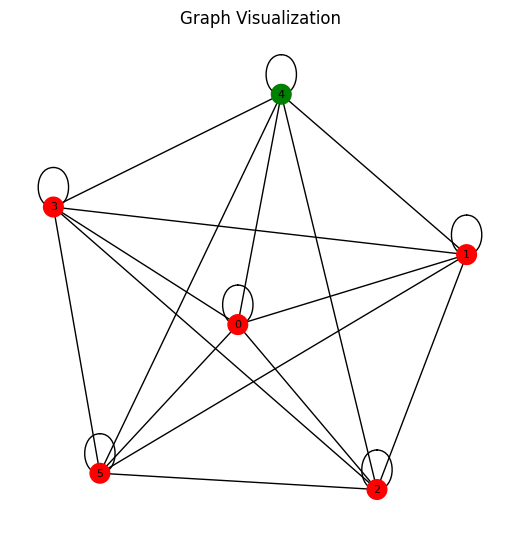

In [8]:
def visualize_geometric_graph(data_sample):
    """
    Visualizes a single torch_geometric.data.Data graph sample.
    """
    # Create a NetworkX graph object
    G = nx.Graph()

    # The edge_index tensor is of shape [2, num_edges].
    # We need to transpose it and convert to a list of tuples.
    edge_list = data_sample.edge_index.t().tolist()

    # Add edges to the graph. Nodes are added automatically.
    G.add_edges_from(edge_list)

    print(f"\nVisualizing Graph...")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    # Use the labels (Y tensor) to color the nodes
    # For example, class 0 is blue, class 1 is red
    colors = ['red' if label == 0 else 'green' for label in data_sample.y] 
    print(data_sample.y)
    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, with_labels=True, node_color=colors, node_size=200, font_size=8)
    plt.title("Graph Visualization")
    plt.show()

# Visualize the first graph in the dataset

visualize_geometric_graph(train_dataset[0])

# Model 1: GConvGRU

In [9]:
from torch_geometric_temporal.nn import GConvGRU

In [10]:
model_GConvGRU = GConvGRU(10, 1, 20).to(device)
sum([p.numel() for p in model_GConvGRU.parameters()])

666

In [11]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Train GConvGRU

# Model 2: DGDNN

GitHub: https://github.com/pixelhero98/DGDNN

In [13]:

from dgdnn import DGDNN 

## Define the model

In [14]:
####  Define model
layers = 6
num_nodes = 6 
expansion_step = 7
num_heads = 2
active_layers = [True, False, False, False, False, False]
timestamp = 17  #window
classes = 1
diffusion_size = [5*timestamp, 31*timestamp, 28*timestamp, 24*timestamp, 20*timestamp, 16*timestamp, 12*timestamp]
emb_size = [5 + 31, 64, 28 + 64, 50,
            24 + 50, 38, 20 + 38, 24,
            16 + 24, 12, 12+12, 10]  

#in_size = previous_output + diffusion_size_i

model = DGDNN(
    diffusion_size=diffusion_size,
    embedding_size=emb_size,
    classes=1,
    layers=layers,
    num_nodes=num_nodes,
    expansion_step=expansion_step,
    num_heads=num_heads,
    active=active_layers,
    timestamp=timestamp
).to(device)

## Train DGDNN

In [15]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [16]:
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1.5e-5)
criterion = nn.BCEWithLogitsLoss() # For binary classification (output is a single logit)
num_epochs = 30

model.train()
for epoch in range(num_epochs): 
    train_loss = .0 #loss for each epoch
    for train_sample in train_loader: 
      train_sample = train_sample.to(device)
      optimizer.zero_grad()
    
      A = to_dense_adj(train_sample.edge_index, 
                        batch=train_sample.batch, # Important for correct batch processing if batch_size > 1
                        edge_attr=train_sample.edge_attr, 
                        max_num_nodes=num_nodes).squeeze(0) # Squeeze for batch_size=1
      
      C = train_sample.y.unsqueeze(dim=1).float()
      # Forward pass
      # DGDNN expects X: [num_nodes, features], A: [num_nodes, num_nodes]
      outputs = model(train_sample.x, A) # Output shape: [num_nodes, classes]

      loss = criterion(outputs, C) - 0.0029 * neighbor_distance_regularizer(model.theta) + theta_regularizer(model.theta)
      
      # Backward pass and optimize
      loss.backward()
      optimizer.step()
      #loss.step()
      train_loss += loss.item()

    # Validation step
    if epoch%5 == 0:
      val_loss =.0 #Reset validation loss
      val_acc = .0 #Reset validation accuracy
      val_f1 = .0 #Reset f1 score
      with torch.no_grad():
        for val_sample in validation_loader:
          val_sample.to(device)
          A = to_dense_adj(val_sample.edge_index, 
                        batch=val_sample.batch, # Important for correct batch processing if batch_size > 1
                        edge_attr=val_sample.edge_attr, 
                        max_num_nodes=num_nodes).squeeze(0) # Squeeze for batch_size=1
          out = model(val_sample.x, A)

          y = val_sample.y.detach().cpu() # Obtain the y labels
          preds = (out > 0).float().detach().cpu().squeeze() #get the predicted logits

          val_loss += criterion(out, val_sample.y.unsqueeze(1).float()).item()
          val_acc += accuracy_score(y, preds)
          val_f1 += f1_score(y, preds)
          #val_mcc += matthews_corrcoef() 

        print(f"Epoch {epoch+1}/{num_epochs},  train_loss={train_loss:.4f}, val_loss={(val_loss/len(validation_loader)):.4f}, val_acc={(val_acc/len(validation_loader)):.4f}, val_f1={(val_f1/len(validation_loader)):.4f}")
     
print("Training finished.")

Epoch 1/30,  train_loss=464.0536, val_loss=0.7087, val_acc=0.4908, val_f1=0.5528


KeyboardInterrupt: 

## Test the model

In [203]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# Use torch.no_grad() for evaluation to improve speed and save memory
model.eval()
criterion = nn.BCEWithLogitsLoss()

all_logits = []
all_labels = []
total_test_loss = 0

with torch.no_grad():  # Deactivates autograd for efficiency
    for test_sample in test_loader:
        test_sample = test_sample.to(device)
        
        # --- X Preparation ---
        X = test_sample.x
        A = to_dense_adj(test_sample.edge_index,
                         batch=test_sample.batch,
                         edge_attr=test_sample.edge_attr,
                         max_num_nodes=num_nodes).squeeze(0)
        
        # Use test_sample.y for labels and prepare for loss calculation
        C = test_sample.y.unsqueeze(dim=1).float() 
        
        # --- Forward pass and Loss Calculation ---
        outputs = model(X, A)
        loss = criterion(outputs, C)  # Note: Regularizers are often omitted during evaluation
        total_test_loss += loss.item()
        
        # --- Accumulate logits and labels ---
      

# TO FINISH ci sta


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x80 and 85x527)

# Model 3. Temporal GNN

In [17]:
class TemporalGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.2):
        super(TemporalGNN, self).__init__()
        self.recurrent1 = GConvGRU(in_channels, hidden_channels, K=2)
        #self.recurrent2 = GConvGRU(hidden_channels, hidden_channels, K=2)
        #self.recurrent3 = GConvGRU(hidden_channels, hidden_channels, K=2)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        h1 = None
        h2 = None
        h3 = None
        h1 = self.recurrent1(x, edge_index, edge_weight, h1)
        #h2 = self.recurrent2(h1, edge_index, edge_weight, h2)
        #h3 = self.recurrent3(h2, edge_index, edge_weight, h3)
        h = F.relu(h1)
        h = self.dropout(h)  # Dropout before final layer
        out = self.linear(h)
        return out


input_dim = 5 * timestamp
hidden_dim = 128
output_dim = 1

model_TemporalGNN = TemporalGNN(input_dim, hidden_dim, output_dim).to(device)
sum([p.numel() for p in model_TemporalGNN.parameters()])

164481

## Train Temporal_GNN

In [18]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [19]:
optimizer = optim.Adam(model_TemporalGNN.parameters(), lr=2e-4, weight_decay=1.5e-5)
criterion = nn.BCEWithLogitsLoss() # For binary classification (output is a single logit)
num_epochs = 30


for epoch in range(num_epochs):
    train_loss = .0
    train_acc = .0
    model_TemporalGNN.train()
    for train_sample in train_loader:
        train_sample.to(device)
        optimizer.zero_grad()
        out = model_TemporalGNN(train_sample.x, train_sample.edge_index, train_sample.edge_weight)
        loss = criterion( out, train_sample.y.unsqueeze(1).float() )
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #train_acc += accuracy_score((out.detach().cpu() > 0).float().squeeze(), validation_dataset[10].y.detach().cpu())

    if epoch%5 == 0:
      val_loss =.0 #Reset validation loss
      val_acc = .0 #Reset validation accuracy
      val_f1 = .0 #Reset f1 score
      with torch.no_grad():
        for val_sample in validation_loader:
          val_sample.to(device)
          out = model_TemporalGNN(val_sample.x, val_sample.edge_index, val_sample.edge_attr)

          y = val_sample.y.detach().cpu() # Obtain the y labels
          preds = (out > 0).float().detach().cpu().squeeze() #get the predicted logits

          val_loss += criterion(out, val_sample.y.unsqueeze(1).float()).item()
          val_acc += accuracy_score(y, preds)
          val_f1 += f1_score(y, preds)
          #val_mcc += matthews_corrcoef() 

        print(f"Epoch {epoch+1}/{num_epochs},  train_loss={train_loss:.4f}, val_loss={(val_loss/len(validation_loader)):.4f}, val_acc={(val_acc/len(validation_loader)):.4f}, val_f1={(val_f1/len(validation_loader)):.4f}")





Epoch 1/30,  train_loss=458.3627, val_loss=0.7047, val_acc=0.4859, val_f1=0.5619
Epoch 6/30,  train_loss=456.1279, val_loss=0.6983, val_acc=0.4965, val_f1=0.5543
Epoch 11/30,  train_loss=455.6608, val_loss=0.6993, val_acc=0.4936, val_f1=0.5567
Epoch 16/30,  train_loss=455.0621, val_loss=0.6953, val_acc=0.5056, val_f1=0.4692
Epoch 21/30,  train_loss=455.4373, val_loss=0.6963, val_acc=0.4929, val_f1=0.5448
Epoch 26/30,  train_loss=454.1345, val_loss=0.7008, val_acc=0.4866, val_f1=0.5898


## Temp maybe usefull

In [20]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal #Handle dynamic temporal graph